## Local installation of segmentation-models, if not already included

In [34]:
! pip install segmentation-models

## Import libraries

In [1]:
from keras.models import *
from keras.layers import *
import tensorflow as tf
from keras.optimizers import *
import keras.backend as K
from keras.utils import plot_model
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np
from PIL import Image
import cv2
import time

from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Using TensorFlow backend.


## Define the image and mask paths

In [35]:
nepochs=15 # define the number of epochs

image_lam_mask_paths = [("../Images1/image_%d.png"%i,
                     "lam_masks/mask_%d.png"%i) for i in range(25,45)] 
                     # store the image file paths for the training data
    
image_dup_mask_paths = [("../Images1/image_%d.png"%i,
                     "dup_masks/mask_%d.png"%i) for i in range(501,521)] 

# divide the data into training and test data
test_lam_paths = image_lam_mask_paths[:int(4)]
train_lam_paths = image_lam_mask_paths[int(4):]
test_dup_paths = image_dup_mask_paths[:int(4)]
train_dup_paths = image_dup_mask_paths[int(4):]
num_train_images = len(train_lam_paths) + len(train_dup_paths)
num_test_images = len(test_lam_paths) + len(test_dup_paths)

## Define the functions to read images with equiaxed and lamellar morphologies

In [4]:
s = 256
def read_dup_data(img_mask_path):
    PIL_image = Image.open(img_mask_path[0])
    img_in = np.array(PIL_image.convert('L'))
    img_in = cv2.resize(img_in, (s,s), interpolation=cv2.INTER_CUBIC)
    thi, img_in = cv2.threshold(img_in,np.median(img_in),255,cv2.THRESH_BINARY)
    img_in = 255 - img_in
    img_in = cv2.medianBlur(img_in, 3)
    #plt.imshow(img_in)
    #img_in = np.reshape(img_in, (np.shape(img_in)[0],np.shape(img_in)[1],1))
    img_in = np.reshape(img_in, (s,s,1))
    PIL_mask = Image.open(img_mask_path[1])
    mask_in = np.array(PIL_mask.convert('L'))
    mask_in = cv2.resize(mask_in, (s,s), interpolation=cv2.INTER_CUBIC)
    #plt.imshow(mask_in)
    #mask_in = np.reshape(mask_in, (np.shape(mask_in)[0],np.shape(mask_in)[1],1))
    thi, mask_in = cv2.threshold(mask_in,np.median(mask_in),255,cv2.THRESH_BINARY)
    mask_in = mask_in/255
    mask_in = mask_in*2
    mask_in = np.reshape(mask_in, (s,s,1))
    mask_in = tf.keras.utils.to_categorical(mask_in, num_classes = 3, dtype ="uint8")
    return (img_in, mask_in)

In [5]:
def read_lam_data(img_mask_path):
    PIL_image = Image.open(img_mask_path[0])
    img_in = np.array(PIL_image.convert('L'))
    img_in = cv2.resize(img_in, (s,s), interpolation=cv2.INTER_CUBIC)
    #thi, img_in = cv2.threshold(img_in,np.median(img_in),255,cv2.THRESH_BINARY)
    #img_in = 255 - img_in
    img_in = cv2.blur(img_in, (3,3))
    img_in = cv2.medianBlur(img_in, 3)
    #thi, img_in = cv2.threshold(img_in,np.median(img_in),255,cv2.THRESH_BINARY)
    #img_in = cv2.blur(img_in, (5,5))
    img_in = np.reshape(img_in, (s,s,1))
    PIL_mask = Image.open(img_mask_path[1])
    mask_in = np.array(PIL_mask.convert('L'))
    mask_in = cv2.resize(mask_in, (s,s), interpolation=cv2.INTER_CUBIC)
    thi, mask_in = cv2.threshold(mask_in,np.median(mask_in),255,cv2.THRESH_BINARY)
    mask_in = mask_in/255
  #plt.imshow(mask_in)
    mask_in = np.reshape(mask_in, (s,s,1))
    mask_in = tf.keras.utils.to_categorical(mask_in, num_classes = 3, dtype ="uint8")
    return (img_in, mask_in)

## Load the images and masks from the pre-defined paths

In [24]:
out_imgs = np.zeros((num_train_images,)+(s,s)+(1,)) # define the input images for the model
out_masks = np.zeros((num_train_images,)+(s,s)+(3,)) # define the input masks for the model
for i, img_mask_path in enumerate(train_lam_paths):
    img, mask = read_lam_data(img_mask_path) # import images, save as array, crop and resize the image to (256,256,1)
    out_imgs[i,...] = img # create single array of images
    out_masks[i,...] = mask # create single array of masks

flag = i
    
for i, img_mask_path in enumerate(train_dup_paths):
    img, mask = read_dup_data(img_mask_path) # import images, save as array, crop and resize the image to (256,256,1)
    out_imgs[i+flag+1,...] = img # create single array of images
    out_masks[i+flag+1,...] = mask # create single array of masks

## Define the exact model to load, specify the dataset of pre-training, & preprocess the input

In [9]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

x_train = preprocess_input(out_imgs)
N = 1

base_model = Unet(BACKBONE, classes = 3, encoder_weights='imagenet')

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)

Segmentation Models: using `keras` framework.


## Compile the model

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Fit the compiled model to the training dataset

In [25]:
model.fit(x=x_train, y=out_masks, batch_size=9, epochs=20, verbose = 1)

Epoch 1/20
32/32 [==============================] - 44s 1s/step - loss: 0.3515 - accuracy: 0.8450
Epoch 2/20
32/32 [==============================] - 34s 1s/step - loss: 0.3501 - accuracy: 0.8456
Epoch 3/20
32/32 [==============================] - 34s 1s/step - loss: 0.3478 - accuracy: 0.8463
Epoch 4/20
32/32 [==============================] - 34s 1s/step - loss: 0.3480 - accuracy: 0.8467
Epoch 5/20
32/32 [==============================] - 34s 1s/step - loss: 0.3507 - accuracy: 0.8461
Epoch 6/20
32/32 [==============================] - 36s 1s/step - loss: 0.3458 - accuracy: 0.8471
Epoch 7/20
32/32 [==============================] - 34s 1s/step - loss: 0.3492 - accuracy: 0.8466
Epoch 8/20
32/32 [==============================] - 34s 1s/step - loss: 0.3458 - accuracy: 0.8472
Epoch 9/20
32/32 [==============================] - 34s 1s/step - loss: 0.3476 - accuracy: 0.8469
Epoch 10/20
32/32 [==============================] - 34s 1s/step - loss: 0.3486 - accuracy: 0.8470
Epoch 11/20
32/32 [

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1fb06462848>)

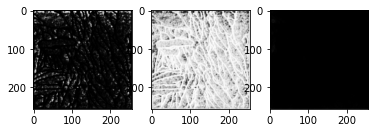

In [26]:
# pre-process the testing data
out_imgs = np.zeros((num_test_images,)+(s,s)+(1,))
out_masks = np.zeros((num_test_images,)+(s,s)+(3,))
for i, img_mask_path in enumerate(test_lam_paths):
    img, mask = read_lam_data(img_mask_path)
    out_imgs[i,...] = img
    out_masks[i,...] = mask
    
flag = i

for i, img_mask_path in enumerate(test_dup_paths):
    img, mask = read_dup_data(img_mask_path)
    out_imgs[i+flag+1,...] = img
    out_masks[i+flag+1,...] = mask

# makes a prediction for our test images using the trained model
prediction = model.predict_on_batch(out_imgs)

#example_pred = prediction[0].reshape(s,s)
plt.subplot(131), plt.imshow(prediction[0][:,:,0], 'gray')
plt.subplot(132), plt.imshow(prediction[0][:,:,1], 'gray')
plt.subplot(133), plt.imshow(prediction[0][:,:,2], 'gray')

#print(np.shape(prediction[0][:,:,1]))

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1fb065c2fc8>)

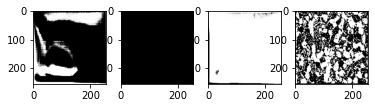

In [27]:
plt.subplot(141), plt.imshow(prediction[7][:,:,0], 'gray')
plt.subplot(142), plt.imshow(prediction[7][:,:,1], 'gray')
plt.subplot(143), plt.imshow(prediction[7][:,:,2], 'gray')
plt.subplot(144), plt.imshow(out_imgs[7], 'gray')

In [23]:
cv2.imwrite('lam_mask_c0.png', (prediction[0][:,:,0]*256).astype('uint8'))
cv2.imwrite('lam_mask_c1.png', (prediction[0][:,:,1]*256).astype('uint8'))
cv2.imwrite('lam_mask_c2.png', (prediction[0][:,:,2]*256).astype('uint8'))

cv2.imwrite('dup_mask_c0.png', (prediction[7][:,:,0]*256).astype('uint8'))
cv2.imwrite('dup_mask_c1.png', (prediction[7][:,:,1]*256).astype('uint8'))
cv2.imwrite('dup_mask_c2.png', (prediction[7][:,:,2]*256).astype('uint8'))

True

0.3956766128540039


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1fb11e776c8>)

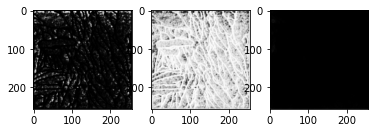

In [33]:
example_img = np.reshape(out_imgs[0], (1,256,256,1))

s = time.time()
prediction = model.predict_on_batch(example_img)
f = time.time()
print(f-s)
#example_pred = prediction[0].reshape(s,s)
plt.subplot(131), plt.imshow(prediction[0][:,:,0], 'gray')
plt.subplot(132), plt.imshow(prediction[0][:,:,1], 'gray')
plt.subplot(133), plt.imshow(prediction[0][:,:,2], 'gray')